In [3]:
import yfinance as yf

# Download historical data for a stock (e.g., Apple)
data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')
print(data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373960  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687305  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021719  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944685  237458000


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Use only the 'Close' price for prediction
data = data[['Close']]

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (e.g., use the past 60 days to predict the next)
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(scaled_data)):
    X_train.append(scaled_data[i-sequence_length:i, 0])  # Last 60 values
    y_train.append(scaled_data[i, 0])  # Target is the next value

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data to be suitable for LSTM: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predict the next stock price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)


C:\Users\jainn\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0669
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0031
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0025
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0029
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0022
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0020
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0022
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0039
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0024
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0017
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0019
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0017
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0015
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0019
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0016
E

In [8]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - sequence_length:]

# Create testing sequences (same as for training)
X_test, y_test = [], []

for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict using the model
predictions = model.predict(X_test)

# Inverse scale the predictions and actual data to compare them in original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


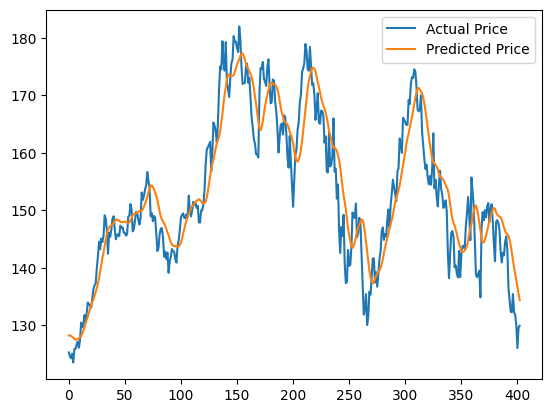

In [9]:
import matplotlib.pyplot as plt

# Plot the predictions vs actual stock prices
plt.plot(y_test_actual, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.legend()
plt.show()


In [13]:
import requests

def get_real_time_stock_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    # Extract the most recent data point
    latest_data = list(data['Time Series (1min)'].values())[0]
    close_price = float(latest_data['4. close'])
    return close_price


def preprocess_and_predict(symbol, model, scaler, api_key):
    # Fetch the latest data
    new_price = get_real_time_stock_data(symbol, api_key)
    
    # Scale the price (use the same scaler used during training)
    scaled_price = scaler.transform([[new_price]])

    # Create a sequence (use the latest 60 prices)
    # Assume you already have the past 59 prices stored
    last_59_prices = ...  # Last 59 prices from previous data
    last_59_prices = np.append(last_59_prices, scaled_price)
    last_59_prices = historical_data[-59:]
    last_59_prices = last_59_prices.reshape(1, 60, 1)  # Reshape for LSTM input

    # Predict the next price
    predicted_price_scaled = model.predict(last_59_prices)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    return predicted_price[0][0]

# Example usage
symbol = 'AAPL'
api_key = 'VM94TOW4YRD2YXCB'
predicted_price = preprocess_and_predict(symbol, model, scaler, api_key)
print(f'Predicted next price for {symbol}: {predicted_price}')


C:\Users\jainn\anaconda3\envs\notebook\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: cannot reshape array of size 2 into shape (1,60,1)

In [14]:
import requests
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd

def get_real_time_stock_data(symbol, api_key):
    """
    Fetches real-time stock data from Alpha Vantage API.
    Returns the most recent close price.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    
    # Extract the most recent data point
    try:
        latest_data = list(data['Time Series (1min)'].values())[0]
        close_price = float(latest_data['4. close'])
    except (KeyError, IndexError):
        raise ValueError("Error fetching real-time data. Please check the API response and symbol.")
    
    return close_price

def preprocess_and_predict(symbol, model, scaler, api_key, last_59_prices):
    """
    Fetches the latest real-time stock price, appends it to the historical data,
    scales the input data, and predicts the next stock price using the LSTM model.
    """
    # Fetch the latest data
    new_price = get_real_time_stock_data(symbol, api_key)
    
    # Scale the new price (use the same scaler used during training)
    scaled_price = scaler.transform([[new_price]])[0, 0]

    # Append the scaled new price to the last 59 prices
    last_59_prices = np.append(last_59_prices, scaled_price)
    
    # Ensure we only have the last 60 prices for prediction
    last_60_prices = last_59_prices[-60:]

    # Reshape for LSTM input (samples, time_steps, features)
    last_60_prices = last_60_prices.reshape(1, 60, 1)
    
    # Predict the next price (scaled)
    predicted_price_scaled = model.predict(last_60_prices)
    
    # Inverse transform the predicted price back to original scale
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    
    return predicted_price[0][0]

# Function to load historical data for initialization (example with a CSV file)
def load_historical_data(symbol, api_key, interval='1min', data_points=60):
    """
    Fetches historical stock prices from the Alpha Vantage API and returns
    the last N data points. This can be used to initialize the LSTM model.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    
    # Extract historical data
    try:
        historical_data = pd.DataFrame(data['Time Series (1min)']).T
        historical_data = historical_data.astype(float)['4. close'].values
    except (KeyError, IndexError):
        raise ValueError("Error fetching historical data. Please check the API response and symbol.")
    
    # Return the last N data points
    return historical_data[:data_points]

# Example usage
if __name__ == '__main__':
    symbol = 'AAPL'  # Example stock symbol
    api_key = 'VM94TOW4YRD2YXCB'  # Replace with your Alpha Vantage API key
    
    # Load a pre-trained LSTM model (make sure you have a trained model saved)
    model = tf.keras.models.load_model('lstm_stock_model.h5')  # Load the trained LSTM model
    
    # Load historical stock prices for the first run (e.g., last 59 prices)
    last_59_prices = load_historical_data(symbol, api_key, data_points=59)
    
    # Initialize the MinMaxScaler (use the same scaler as during training)
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit the scaler with the historical data (make sure you used the same range during training)
    last_59_prices_reshaped = last_59_prices.reshape(-1, 1)
    scaler.fit(last_59_prices_reshaped)
    
    # Now, predict the next stock price using real-time data
    predicted_price = preprocess_and_predict(symbol, model, scaler, api_key, last_59_prices)
    
    print(f'Predicted next price for {symbol}: {predicted_price}')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'lstm_stock_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [15]:
import requests
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Function to get real-time stock data
def get_real_time_stock_data(symbol, api_key):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    # Extract the most recent data point
    try:
        latest_data = list(data['Time Series (1min)'].values())[0]
        close_price = float(latest_data['4. close'])
    except (KeyError, IndexError):
        raise ValueError("Error fetching real-time data. Please check the API response and symbol.")
    
    return close_price

# Function to load historical data for training the model
def load_historical_data(symbol, api_key, interval='1min', data_points=60):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    # Extract historical data
    try:
        historical_data = pd.DataFrame(data['Time Series (1min)']).T
        historical_data = historical_data.astype(float)['4. close'].values
    except (KeyError, IndexError):
        raise ValueError("Error fetching historical data. Please check the API response and symbol.")
    
    # Return the last N data points
    return historical_data[:data_points]

# Preprocessing data for LSTM model
def preprocess_data(data, scaler):
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(data_scaled)):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input
    return X, y

# Building and training the LSTM model
def build_and_train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model (this is just an example, you may want to train with more epochs)
    model.fit(X_train, y_train, epochs=5, batch_size=32)
    
    return model

# Function to preprocess and predict next stock price
def preprocess_and_predict(symbol, model, scaler, api_key, last_59_prices):
    new_price = get_real_time_stock_data(symbol, api_key)
    
    # Scale the new price (use the same scaler)
    scaled_price = scaler.transform([[new_price]])[0, 0]
    
    # Append the new price to the historical data
    last_59_prices = np.append(last_59_prices, scaled_price)[-60:]  # Keep only last 60 points
    
    # Reshape for LSTM input
    last_60_prices = last_59_prices.reshape(1, 60, 1)
    
    # Predict the next price (scaled)
    predicted_price_scaled = model.predict(last_60_prices)
    
    # Inverse transform the predicted price
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    
    return predicted_price[0][0]

# Example usage
if __name__ == '__main__':
    symbol = 'AAPL'  # Example stock symbol
    api_key = 'VM94TOW4YRD2YXCB'  # Replace with your Alpha Vantage API key
    
    # Step 1: Load historical stock prices
    historical_data = load_historical_data(symbol, api_key, data_points=500)  # Get 500 historical data points
    
    # Step 2: Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train, y_train = preprocess_data(historical_data, scaler)
    
    # Step 3: Build and train the LSTM model (without saving to file)
    model = build_and_train_model(X_train, y_train)
    
    # Step 4: Predict the next stock price using real-time data
    last_59_prices = historical_data[-59:]  # Last 59 prices from historical data
    predicted_price = preprocess_and_predict(symbol, model, scaler, api_key, last_59_prices)
    
    print(f'Predicted next price for {symbol}: {predicted_price}')

C:\Users\jainn\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.4504
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3199
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1749 
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0948 
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
Predicted next price for AAPL: 234.986328125
